In [1]:
import numpy as np
import sys
import torch
import torch.nn as nn
sys.path.append('..')
import MLMD

# 读取XDATCAR文件，步长为1fs

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
LiF = MLMD.atom_io.loadfile(1,"data/XDATCAR")

Reading XDATCAR...
F      : 32
Li     : 30
Loading XDATCAR...
done


# 制作测试集

In [3]:
train_data = np.array([np.array(np.append(LiF["F"].position[i],LiF["Li"].position[i])) for i in range(len(LiF["F"].position))])
def diff(data):
    #输入train data并差分
    v = []
    for i in range(1,len(data)):
        v.append(data[i]-data[i-1])
    return v

#直角坐标
v = diff(train_data)
#球坐标
v_s = [MLMD.neighbor_list.cartesian_to_spherical(v[i].reshape(-1,3)) for i in range(len(v))]


#临近表的建立

neighborlist = MLMD.neighbor_list.get_neighbor_atoms(train_data[0].reshape(-1,3),cutoff = 10,lattice = LiF["Li"].lattice)
neighbor_coord = []
for i in range(1000):
    neighboratom = MLMD.neighbor_list.get_coordinates_from_indices(train_data[i].reshape(-1,3),neighborlist)
    for j ,k in enumerate(neighboratom):
        #平移到中心           
        vector_3d = np.tile(train_data[i].reshape(-1,3)[j],(k.shape[0],1))
        if i == 0:
            #WS原胞中心 MLMD.neighbor_list.special_translate2(k-vector_3d,lattice = LiF["Li"].lattice)
            #球坐标 MLMD.neighbor_list.cartesian_to_spherical(k-vector_3d)
            neighbor_coord.append([k-vector_3d])#
        else:
            neighbor_coord[j].append(k-vector_3d)

# 可视化临近坐标和速度

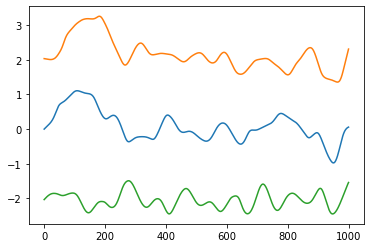

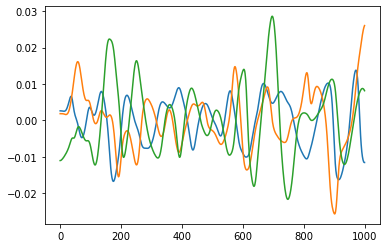

In [4]:
#print(np.array([neighbor_coord[1][i][0] for i in range(50)]))
import matplotlib.pyplot as plt
plt.figure()
for j in range(1):
    plt.plot(np.array([neighbor_coord[3][i][j] for i in range(1000)]))
plt.figure()
for j in range(1):
    plt.plot(np.array([v[i][3*j:3*j+3] for i in range(1000)]))

# 制作原子类型表（对网络重要）

In [5]:
neighbor_atom_kind = []
for i in neighborlist:
    atom_kind_list = [1 if x <= 31 else 2 for x in i]
    neighbor_atom_kind.append(atom_kind_list)
print(neighbor_atom_kind[31])#1是F 2是Li

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


# 至此我们获得了一个名叫neighbor_coord的list，每一项为对应原子序数的临近原子100帧内的运动轨迹，如第0个原子视角下，第一个原子10帧内的运动:

In [6]:
print(np.array([neighbor_coord[1][i][0] for i in range(10)]))

[[-2.04263798  2.0285415  -0.00513877]
 [-2.0313592   2.02708309 -0.03304261]
 [-2.02011175  2.02561745 -0.06090742]
 [-2.00891943  2.02412942 -0.08867096]
 [-1.99780772  2.02260861 -0.11628437]
 [-1.98679516  2.02104146 -0.14371544]
 [-1.97589044  2.01941271 -0.17092774]
 [-1.96512749  2.01770956 -0.19789009]
 [-1.95452517  2.01591705 -0.2245625 ]
 [-1.9440935   2.01401281 -0.25092751]]


# 开始训练第一个原子（激动）

Epoch [50/200], Loss: 2.354e-06
Epoch [100/200], Loss: 6.237e-08
Epoch [150/200], Loss: 7.436e-08
Epoch [200/200], Loss: 1.366e-08


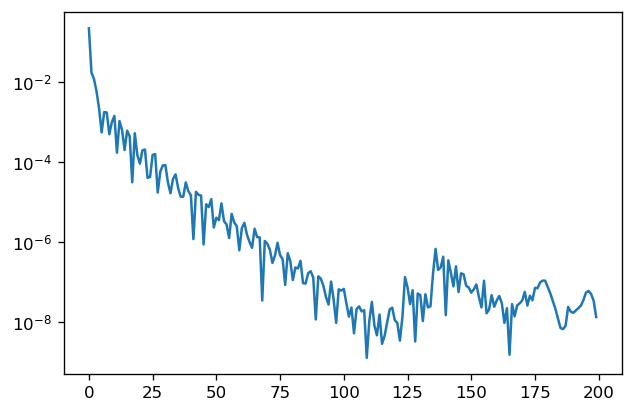

In [22]:
#模型的构建
embed_layers = [16,64,32,8]
linear_layers = [64,256,64,32]
atom = 1
atom_list = neighbor_atom_kind[0]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MLMD.model.DNN_sym(atom, atom_list, embed_layers, linear_layers).to(device)
#print(model)


num_epochs = 200
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.004 )#0.005挺好 weight_decay=1e-4

scheduler = MLMD.model.SchedulerCosineDecayWarmup(optimizer, 0.004, 10, 400)

loss_array = []   #draw picture

# 训练第一个原子的临近行为
for epoch in range(num_epochs):
    # Get the input and target arrays
    
    input_array = torch.from_numpy(neighbor_coord[0][epoch]).float().to(device)
    target_array = torch.from_numpy(v[epoch].reshape(-1,3)[0]).float().to(device)   #train_data+1 v不加
    output_array = model(input_array)

    loss = criterion(output_array, target_array)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    if (epoch+1) % 50 == 0:
        print('Epoch [{}/{}], Loss: {:.3e}'.format(epoch+1, num_epochs, loss.item()))
    loss_array.append(loss.item())

import matplotlib.pyplot as plt
plt.figure(dpi=120)
plt.plot(loss_array)
plt.yscale("log")

In [23]:
ta = target_array.cpu().numpy()
oa = output_array.cpu().detach().numpy()

print(ta,oa,loss)
print(np.linalg.norm(ta-oa)/np.linalg.norm(ta))
#print(target_array - output_array)

[-0.00377561 -0.01128224 -0.00300463] [-0.00389879 -0.01138273 -0.00287932] tensor(1.3658e-08, device='cuda:0', grad_fn=<MseLossBackward0>)
0.016495887


# 一个的时候效果好到飞起！接下来训练所有的原子

第 1个原子，Loss: 5.29998e-07,cpu time: 4.78s
第 2个原子，Loss: 2.84067e-08,cpu time: 5.05s
第 3个原子，Loss: 4.47372e-08,cpu time: 4.79s
第 4个原子，Loss: 8.71146e-08,cpu time: 4.59s
第 5个原子，Loss: 2.48157e-09,cpu time: 4.70s
第 6个原子，Loss: 8.94643e-07,cpu time: 4.69s
第 7个原子，Loss: 2.46955e-08,cpu time: 4.86s
第 8个原子，Loss: 3.16436e-07,cpu time: 4.93s
第 9个原子，Loss: 7.55520e-10,cpu time: 4.82s
第10个原子，Loss: 2.21318e-08,cpu time: 4.68s
第11个原子，Loss: 1.50048e-08,cpu time: 5.00s
第12个原子，Loss: 6.38849e-08,cpu time: 4.84s
第13个原子，Loss: 2.98184e-08,cpu time: 4.66s
第14个原子，Loss: 5.24903e-09,cpu time: 4.66s
第15个原子，Loss: 9.96464e-09,cpu time: 4.59s
第16个原子，Loss: 3.47340e-08,cpu time: 4.73s
第17个原子，Loss: 2.81041e-08,cpu time: 4.70s
第18个原子，Loss: 9.16628e-09,cpu time: 4.65s
第19个原子，Loss: 1.50121e-06,cpu time: 4.67s
第20个原子，Loss: 2.11906e-07,cpu time: 4.74s
第21个原子，Loss: 3.64274e-09,cpu time: 4.96s
第22个原子，Loss: 9.26319e-08,cpu time: 5.02s
第23个原子，Loss: 8.00670e-09,cpu time: 4.81s
第24个原子，Loss: 3.34749e-07,cpu time: 4.60s
第25个原子，Loss: 1.1

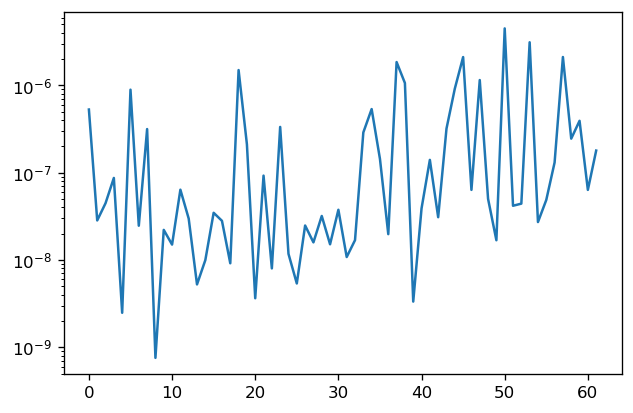

In [25]:
model_list = []
loss_array = [] #每个原子训练200轮的loss

import time

for atom_num in range (62):
    time1 = time.time()
    atom = 1 if atom_num <=31 else 2
    atom_list = neighbor_atom_kind[atom_num]
    
    
    model_list.append(MLMD.model.DNN_sym(atom, atom_list, embed_layers, linear_layers).to(device))
    model = model_list[-1]
    #print(model_list[-1])
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr = 0.006)
    scheduler = MLMD.model.SchedulerCosineDecayWarmup(optimizer, 0.005, 20, 300)
    
    
    num_epochs = 125
    for epoch in range(num_epochs):
    
        input_array = torch.from_numpy(neighbor_coord[atom_num][epoch]).float().to(device)
        target_array = torch.from_numpy(v[epoch].reshape(-1,3)[atom_num]).float().to(device)   #train_data+1 v不加
        output_array = model(input_array)

        loss = criterion(output_array, target_array)
        optimizer.zero_grad()
        loss.backward()  
        optimizer.step()
        scheduler.step()
        #Print the loss every 10 epochs
        #if (epoch+1) % 50 == 0:
            #print('Epoch [{}/{}], Loss: {:.9f}'.format(epoch+1, num_epochs, loss.item()))
    loss_array.append(loss.item())
    time2 = time.time()
    print("第{:2d}个原子，Loss: {:.5e},cpu time: {:.2f}s".format(atom_num+1,loss.item(),time2-time1))

    
plt.figure(dpi=120)
plt.plot(loss_array)
plt.yscale("log")

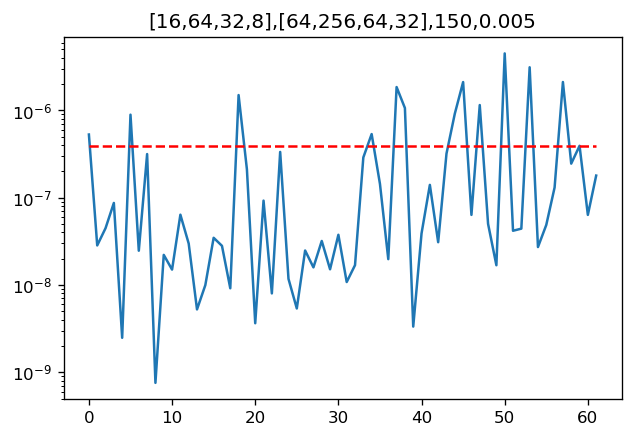

In [27]:
plt.figure(dpi=120)
plt.title("[16,64,32,8],[64,256,64,32],150,0.005")
plt.plot(loss_array)
plt.hlines(np.mean(loss_array),0,61,"r","--")
plt.yscale("log")

# 更新下一个帧原子的速度

In [56]:
def predict_v(coord,model_list,atoms):
    v_pre = []
    for atom_num in range (atoms):
        model = model_list[atom_num]
        with torch.no_grad():
            output_array = model(torch.from_numpy(coord[atom_num]).float().to(device))
        v_pre.append(output_array.cpu().numpy())    
    return np.array(v_pre)

In [57]:
#print([neighbor_coord[i][101] for i in range(62)])

In [58]:
# Get the input array for prediction
start_frame = 125

v_predicted = predict_v([neighbor_coord[i][start_frame] for i in range(62)],model_list,62)

#print(v_predicted)

In [59]:
j = 125
#print(v_predicted - v[j].reshape(-1,3))
print((np.linalg.norm(v_predicted - v[j].reshape(-1,3)))/np.linalg.norm(v[j].reshape(-1,3)))
#print(v[150].reshape(-1,3))

0.07053893495092947


# 往后更新五帧，每一帧和真实的数据比较RMSD（之后的还没写）

In [380]:
predict_coord = []
predict_num = 5
for i in range(predict_num):
    pass


In [145]:
import ase
from ase.io import read ,write
from ase.build import sort
from ase.visualize import view

# 将某一帧写出

In [12]:
"""with open('LiF.vasp', 'w') as f:
    f.write("vasp\n")
    f.write("1.0\n")
    for i in (LiF["F"].lattice):
        f.write(str(i)[1:-1]+"\n")
    for (i,j) in LiF.items():
        f.write(j.name + " ")
    f.write("\n")
    for (i,j) in LiF.items():
        f.write(str(j.number) + " ")
    f.write("\n")
    f.write("Direct\n")
    for i in output_array.reshape(-1,3):
        f.write(str(i)[1:-1]+"\n")
bulk = read("LiF.vasp")
view(bulk)"""

'with open(\'LiF.vasp\', \'w\') as f:\n    f.write("vasp\n")\n    f.write("1.0\n")\n    for i in (LiF["F"].lattice):\n        f.write(str(i)[1:-1]+"\n")\n    for (i,j) in LiF.items():\n        f.write(j.name + " ")\n    f.write("\n")\n    for (i,j) in LiF.items():\n        f.write(str(j.number) + " ")\n    f.write("\n")\n    f.write("Direct\n")\n    for i in output_array.reshape(-1,3):\n        f.write(str(i)[1:-1]+"\n")\nbulk = read("LiF.vasp")\nview(bulk)'

# 跑100步写成xdatcar00

In [13]:
running_test = []
running_test.append(train_data[1000].tolist())

In [16]:
#def pbc_res(frame):
#    #在更新位置时考虑周期性边界条件
#    frame[frame < 0] += 1
#    frame[frame > 1] -= 1
#    return np.array(frame)

for i in range(100):
    input_array = torch.from_numpy(np.array(running_test[-1]).reshape(-1)).float().to(device)
    with torch.no_grad():
        output_array = model(input_array)
    running_test.append(output_array.cpu().numpy() + np.array(running_test[-1]).reshape(-1))
with open('XDATCAR00', 'w') as f:
    f.write("vasp\n")
    f.write("1.0\n")
    for i in (LiF["F"].lattice):
        f.write(str(i)[1:-1]+"\n")
    for (i,j) in LiF.items():
        f.write(j.name + " ")
    f.write("\n")
    for (i,j) in LiF.items():
        f.write(str(j.number) + " ")
    f.write("\n")
    for i in range(len(running_test)):
        f.write("Direct configuration=       "+str(i+1)+"\n")
        for j in np.array(running_test[i]).reshape(-1,3):
            f.write(str(j)[1:-1]+"\n")    